In [6]:
from keras.datasets import fashion_mnist
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import wandb

In [89]:
# Start a new wandb run to track this script.
run = wandb.init(
    # Set the wandb entity where your project will be logged (generally your team name).
    entity="da24m023-indian-institute-of-technology-madras",
    # Set the wandb project where this run will be logged.
    project="testing2",
    # Track hyperparameters and run metadata.
    config={
        "learning_rate": 0.02,
        "architecture": "CNN",
        "dataset": "CIFAR-100",
        "epochs": 10,
    },
)

In [86]:
mnist = fashion_mnist.load_data()
(x_train, y_train), (x_test, y_test) = mnist

classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Question 1 (2 Marks)
Download the fashion-MNIST dataset and plot 1 sample image for each class as shown in the grid below. Use from keras.datasets import fashion_mnist for getting the fashion mnist dataset.

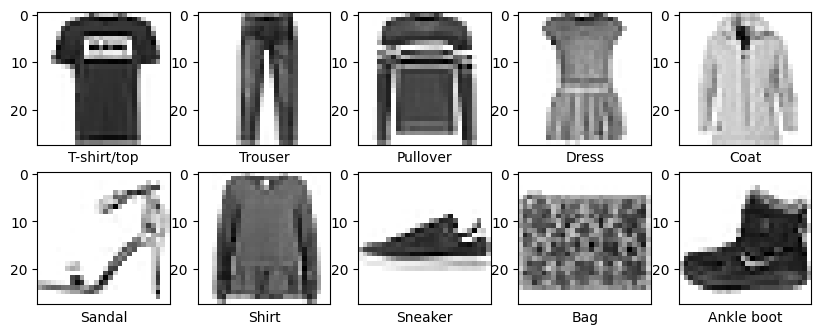

In [ ]:
num_classes = len(classes)

plt.figure(figsize=(10, 10))

imgs = []
imgclasses = []

for i in range(num_classes):
    idx = np.where(y_train == i)[0][0]
    imgs.append(x_train[idx])
    imgclasses.append(classes[i])
    
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.imshow(x_train[idx], cmap=plt.cm.binary)
    plt.xlabel(classes[i])

plt.show()
run.log({"SampleImgs": [wandb.Image(img, caption=caption) for (img, caption) in zip(imgs,imgclasses)]})
run.finish()

# Question 2 (10 Marks)
Implement a feedforward neural network which takes images from the fashion-mnist data as input and outputs a probability distribution over the 10 classes.<br>
Your code should be flexible such that it is easy to change the number of hidden layers and the number of neurons in each hidden layer.

In [ ]:

def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return (x > 0).astype(float)

def one_hot_encode(y, num_classes=10):
    return np.eye(num_classes)[y]

class NeuralNet:
    def __init__(self, input_size, hidden_layers, output_size=10):
        self.layers = [input_size] + hidden_layers + [output_size]
        self.n_layers = len(self.layers)
        self.weights = [np.random.randn(self.layers[i], self.layers[i+1])*0.05 for i in range(self.n_layers-1)]
        self.biases = [np.zeros((1, self.layers[i+1])) for i in range(self.n_layers-1)]
    
    def forward(self, X):
        self.a = [X]
        self.z = []
        for i in range(len(self.weights) - 1):
            z = np.dot(self.a[-1], self.weights[i]) + self.biases[i]
            self.z.append(z)
            self.a.append(relu(z))
        z = np.dot(self.a[-1], self.weights[-1]) + self.biases[-1]
        self.z.append(z)
        self.a.append(softmax(z))
        output = self.a[-1]
        return output
    
    def backward(self, X, y, lr=0.01, mse=False):
        m = X.shape[0]
        
        if mse:
            dz = (self.a[-1] - y) * (2 / m) #MSE backpropogation
        else:
            dz = self.a[-1] - y #Cross Entropy backpropogation
        
        dw = np.dot(self.a[-2].T, dz) / m
        db = np.sum(dz, axis=0, keepdims=True) / m
        
        self.weights[-1] -= lr * dw
        self.biases[-1] -= lr * db
        
        for i in range(len(self.weights)-2, -1, -1):
            dz = np.dot(dz, self.weights[i+1].T) * relu_derivative(self.z[i])
            dw = np.dot(self.a[i].T, dz) / m
            db = np.sum(dz, axis=0, keepdims=True) / m
            
            self.weights[i] -= lr * dw
            self.biases[i] -= lr * db
    
    def train(self, x, y, epochs=10, lr=0.01, mse=False):
        if mse:
            print("Using MSE as Loss")
        else:
            print("Using Cross Entropy as Loss")
        for epoch in range(epochs):
            print(len(self.weights[1]))
            y_pred = self.forward(x)

            if mse:
                #print("Using MSE as Loss")
                loss = np.mean((y - y_pred) ** 2) #MSE
            else:
                #print("Using Cross Entropy as Loss")
                loss = -np.mean(y * np.log(y_pred + 1e-8)) #Cross-entropy loss with epsilon to prevent log(0)
            
            self.backward(x, y, lr)
            print(f"Epoch {epoch+1}/{epochs}, Loss: {loss:.4f}")
    
    def predict(self, x):
        return np.argmax(self.forward(x), axis=1)


In [106]:
# Load and preprocess Fashion-MNIST data
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
#(x_train_, y_train_), (x_test_, y_test_) = fashion_mnist.load_data()
x_train, x_test = x_train.reshape(-1, 784)/255.0, x_test.reshape(-1, 784)/255.0
y_train, y_test = one_hot_encode(y_train), one_hot_encode(y_test)

# Initialize and train the network
nn = NeuralNet(input_size=784, hidden_layers=[256, 128], output_size=10)
nn.train(x_train[:20000], y_train[:20000], epochs=30, lr=0.07, mse=False)

# Evaluate on test data
y_pred = nn.predict(x_test[:5000])
y_true = np.argmax(y_test[:5000], axis=1)
accuracy = np.mean(y_pred == y_true)
print(f"Test Accuracy: {accuracy:.4f}")

Using Cross Entropy as Loss
256
Epoch 1/30, Loss: 0.2306
256
Epoch 2/30, Loss: 0.2283
256
Epoch 3/30, Loss: 0.2262
256
Epoch 4/30, Loss: 0.2242
256
Epoch 5/30, Loss: 0.2222
256
Epoch 6/30, Loss: 0.2202
256
Epoch 7/30, Loss: 0.2181
256
Epoch 8/30, Loss: 0.2160
256
Epoch 9/30, Loss: 0.2139
256
Epoch 10/30, Loss: 0.2116
256
Epoch 11/30, Loss: 0.2092
256
Epoch 12/30, Loss: 0.2067
256
Epoch 13/30, Loss: 0.2040
256
Epoch 14/30, Loss: 0.2013
256
Epoch 15/30, Loss: 0.1984
256
Epoch 16/30, Loss: 0.1954
256
Epoch 17/30, Loss: 0.1923
256
Epoch 18/30, Loss: 0.1891
256
Epoch 19/30, Loss: 0.1859
256
Epoch 20/30, Loss: 0.1826
256
Epoch 21/30, Loss: 0.1792
256
Epoch 22/30, Loss: 0.1758
256
Epoch 23/30, Loss: 0.1725
256
Epoch 24/30, Loss: 0.1691
256
Epoch 25/30, Loss: 0.1658
256
Epoch 26/30, Loss: 0.1625
256
Epoch 27/30, Loss: 0.1593
256
Epoch 28/30, Loss: 0.1561
256
Epoch 29/30, Loss: 0.1530
256
Epoch 30/30, Loss: 0.1501
Test Accuracy: 0.6250


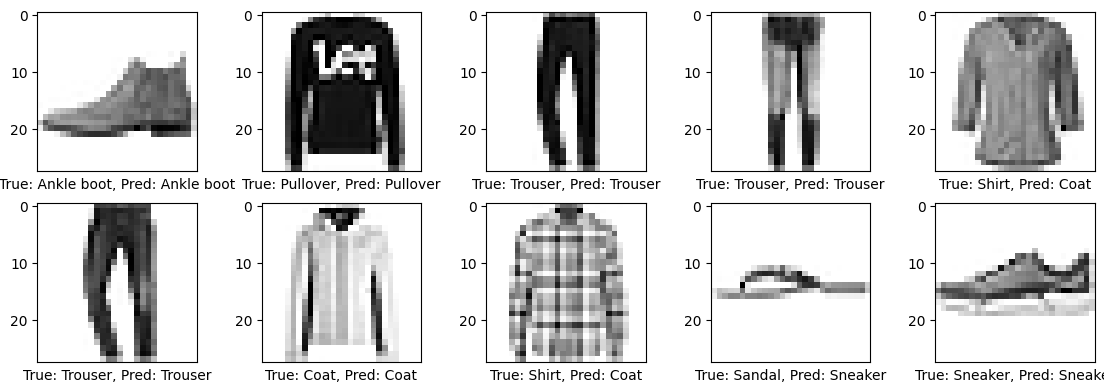

In [102]:
#print(y_test[:10])
#print(np.argmax(y_test[:10], axis=1))
#print([classes[row] for row in np.argmax(y_test[:10], axis=1)])

plt.figure(figsize=(14, 12))
for i in range(10):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.imshow(x_test[i].reshape(28, 28), cmap='binary')
    plt.xlabel(f"True: {classes[y_true[i]]}, Pred: {classes[y_pred[i]]}")